# word2vec (Skpigram vs Negative sampling skipgram)

## 1.Load data

### import library

In [1]:
import numpy as np 
import torch
import torch.nn as nn
from collections import Counter
import torch.optim as optim 
import matplotlib.pyplot as plt 
import spacy
import pandas as pd 
import time
import random
from numpy import dot
from numpy.linalg import norm
import itertools
nlp = spacy.load("en_core_web_sm") #imprement spacy to tokenized data

### Load corpus data from CSV File

In [2]:
df = pd.read_csv('corpus.csv') #load data from CSV
all_text = df.text #get data from "text" column

## 2.Tokenized

In [3]:
corpus_tokenized_str = []
for doc in all_text :
    for token in nlp(doc) :
        corpus_tokenized_str.append(str(token))

In [4]:
corpus_tokenized_str[:10]

[' ', 'Stuning', 'even', 'for', 'the', 'non', '-', 'gamer', ':', 'This']

In [5]:
vocabs = list(set(corpus_tokenized_str))
vocabs[:10]

['WM',
 'noticed',
 'short',
 'beginning',
 'forget',
 'what',
 'volume',
 'Burning',
 'world',
 'haze']

## 3.Numerization

In [6]:
word_2_idx = {v: idx for idx, v in enumerate(vocabs)} #

In [7]:
print(word_2_idx["Japan"]) #See index of word "Japan"

258


In [8]:
vocabs.append('<UNK>')
word_2_idx['<UNK>'] = len(word_2_idx) 

In [9]:
dict(itertools.islice(word_2_idx.items(), 10)) #show example of numerization krub

{'WM': 0,
 'noticed': 1,
 'short': 2,
 'beginning': 3,
 'forget': 4,
 'what': 5,
 'volume': 6,
 'Burning': 7,
 'world': 8,
 'haze': 9}

## 4.Prepare data

In [10]:
def random_batch(batch_size, corpus_tokenized_str):
    skipgrams = []
    #for each corpus
    for sent in corpus_tokenized_str:
        try :
            for i in range(2, len(sent) - 2): #start from 2 to third last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-2]], word_2_idx[sent[i-1]], word_2_idx[sent[i+1]], word_2_idx[sent[i+2]]]  #window size of two 
                for sub_outside in outside_words:
                    skipgrams.append([center_word, sub_outside]) #use center word to predict outside word 
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(skipgrams)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    
    for index in random_index:
        random_inputs.append([skipgrams[index][0]])  #center words, this will be a shape of (1, ) --> (1, 1) for modeling
        random_labels.append([skipgrams[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 5.Negative sampling

In [11]:
Z = 0.001
unigram_table = []

In [12]:
word_count = Counter(corpus_tokenized_str)
num_total_words = sum([c for w, c in word_count.items()])
for vo in vocabs:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [13]:
aa = Counter(unigram_table) #define unigram table
dict(itertools.islice(aa.items(), 10))

{'WM': 1,
 'noticed': 1,
 'short': 2,
 'beginning': 2,
 'forget': 1,
 'what': 8,
 'volume': 1,
 'Burning': 1,
 'world': 2,
 'haze': 1}

In [14]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word_2_idx[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word_2_idx).view(1, -1))
    
    return torch.cat(neg_samples)

## 6.Model

In [15]:
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()
                    
    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) 
        target_embeds = self.embedding_u(target_words) 
        neg_embeds    = -self.embedding_u(negative_words) 
        
        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        
        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1) #Loss Function
                
        return -torch.mean(loss)
    
    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)
        
        return embeds

In [16]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  #is a lookup table mapping all ids in voc_size, into some vector of size emb_size
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     
        outside_word_embed = self.embedding_outside_word(outside_word)   
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

## 7.train

In [17]:
batch_size     = 2 # mini-batch size
voc_size = len(vocabs)
embedding_size = 2 # embeding size of 2
num_neg        = 10 # num of negative sampling
num_epochs = 5000

In [18]:
model_Neg = SkipgramNegSampling(voc_size, embedding_size)
model_normal = Skipgram(voc_size, embedding_size)
optimizer_Neg = optim.Adam(model_Neg.parameters(), lr=0.00095)
optimizer_normal = optim.Adam(model_normal.parameters(), lr=0.00095)

In [19]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word_2_idx).expand(batch_size, voc_size)
all_vocabs.shape #Shape of all vocabs

torch.Size([2, 1600])

In [22]:
def epoch_time(start_time, end_time):
    elapsed_time = (end_time - start_time)
    return elapsed_time

In [23]:
#No negative Training Loop
run_time_normal = 0
sum_time_normal = 0
#for epoch
for epoch in range(num_epochs):
    start = time.time()

    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized_str)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    # print(input_batch.shape, label_batch.shape, all_vocabs.shape)
    
    #loss = model
    loss = model_normal(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer_normal.step()
    end = time.time()
    run_time_normal = run_time_normal + epoch_time(start, end)

    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time_normal += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal:.4f} s")
        run_time_normal = 0
print(f"time when run {num_epochs} epoch is : {sum_time_normal} s")        

Epoch 1000 | Loss: 2.872351 | Time: 4.4263
Epoch 2000 | Loss: 0.603789 | Time: 3.9113
Epoch 3000 | Loss: 0.711816 | Time: 3.8653
Epoch 4000 | Loss: 1.062218 | Time: 3.8093
Epoch 5000 | Loss: 0.753919 | Time: 3.7473
time when run 5000 epoch is : 19.759438514709473 s


In [36]:
# Training for negative
import time 
run_time_negative = 0
sum_time_negative = 0


for epoch in range(num_epochs):
    
    start = time.time()
    input_batch, target_batch = random_batch(batch_size, corpus_tokenized_str)
    input_batch = torch.LongTensor(input_batch)
    target_batch = torch.LongTensor(target_batch)
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)
    optimizer_Neg.zero_grad()
    loss = model_Neg(input_batch, target_batch, negs_batch)
    # epoch_mins, epoch_secs = epoch_time(start, end)
    loss.backward()
    optimizer_Neg.step()
    end = time.time()
    run_time_negative = run_time_negative + epoch_time(start, end)

    if (epoch + 1) % 1000 == 0:
        sum_time_negative += run_time_negative
        print(f"Epoch: {epoch + 1} | loss: {loss:.6f} | time: {run_time_negative} s")
        run_time_negative = 0
print(f"time when run {num_epochs} epoch is : {sum_time_negative} s")     

Epoch: 1000 | loss: 6.697902 | time: 1.3751027584075928 s
Epoch: 2000 | loss: 2.882289 | time: 1.2921011447906494 s
Epoch: 3000 | loss: 2.255446 | time: 1.2990844249725342 s
Epoch: 4000 | loss: 1.493658 | time: 1.3140859603881836 s
Epoch: 5000 | loss: 2.683238 | time: 1.2690927982330322 s
time when run 5000 epoch is : 6.549467086791992 s


when compare the term of time of normal version of skipgrams is 19.76 sec and for negative sampling version is 6.55 sec . In summary negative sampling faster than normal version 13.21 sec!!! .

## 8.Inferance

In [25]:
def get_embed_normal(word): #No negative
    try:
        index = word_2_idx[word]
    except:
        index = word_2_idx['<UNK>']
    word = torch.LongTensor([index])
    center_embed  = model_normal.embedding_center_word(word)
    outside_embed = model_normal.embedding_outside_word(word)
    embed = (center_embed + outside_embed) / 2
    return  embed[0][0].item(), embed[0][1].item()


In [26]:
def get_embed_negative(word): #Negative
    id_tensor = torch.LongTensor([word_2_idx[word]])
    v_embed = model_Neg.embedding_v(id_tensor)
    u_embed = model_Neg.embedding_u(id_tensor) 
    word_embed = (v_embed + u_embed) / 2 
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

### plot the data

#### normal version of skipgrams

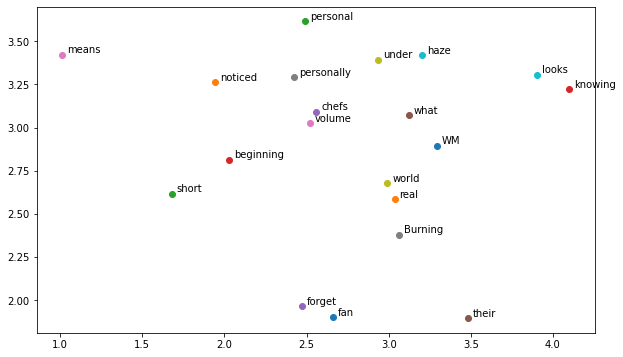

In [27]:
# for no negative sampling
plt.figure(figsize=(10,6))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed_normal(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

#### negative sampling version of skipgrams

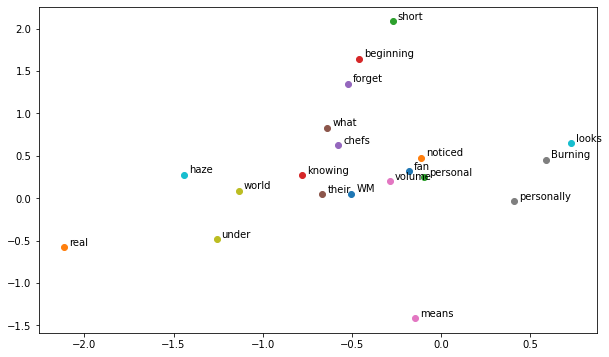

In [37]:
#for negative sampling model
plt.figure(figsize=(10,6))
for i, word in enumerate(vocabs[:20]): #loop each unique vocab
    x, y = get_embed_negative(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Similarity test

In [29]:
cos_sim = lambda a,b : dot(a, b)/(norm(a)*norm(b)) #Define cosine similarity function to check how similarity of two word

In [31]:
def test_senario_normal(a1 , a2) :
    tester1 = get_embed_normal(a1)
    teater2 = get_embed_normal(a2)
    print(f"{a1} similarity to {a2} = {cos_sim(tester1 , teater2)}")

In [30]:
def test_senario_Negative(a1 , a2) : #define test function 
    tester1 = get_embed_negative(a1)
    teater2 = get_embed_negative(a2)
    print(f"{a1} similarity to {a2} = {cos_sim(tester1 , teater2)}")

In [35]:
test_senario_normal("Japan","English")
test_senario_normal("price","price")
test_senario_normal("forget","Japan") 

Japan similarity to English = 0.9898521492593471
price similarity to price = 0.9999999999999999
forget similarity to Japan = 0.9986266872546342


In [38]:
test_senario_Negative("Japan","English")
test_senario_Negative("price","price")
test_senario_Negative("store","several")

Japan similarity to English = 0.41393476241304344
price similarity to price = 1.0
store similarity to several = 0.11574518249635636
